<h1>Flight Delay & Cancellation Data<h1>

<h2>introduction<h2>

The dataset contains information on over 1 million US flights in 2024, capturing details on departure times, cancellations, flight distances, weather delays, and late aircraft delays. It provides a comprehensive view of airline performance and allows analysis of factors contributing to flight delays and cancellations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df=pd.read_csv(r'c:\Data science\ML_Project\flight_data_2024.csv')
print(df.head())

   year  month  day_of_month  day_of_week   fl_date origin origin_city_name  \
0  2024      1             1            1  1/1/2024    JFK     New York, NY   
1  2024      1             1            1  1/1/2024    MSP  Minneapolis, MN   
2  2024      1             1            1  1/1/2024    JFK     New York, NY   
3  2024      1             1            1  1/1/2024    RIC     Richmond, VA   
4  2024      1             1            1  1/1/2024    DTW      Detroit, MI   

  origin_state_nm  dep_time  taxi_out  wheels_off  wheels_on  taxi_in  \
0        New York    1247.0      31.0      1318.0     1442.0      7.0   
1       Minnesota    1001.0      20.0      1021.0     1249.0      6.0   
2        New York    1411.0      21.0      1432.0     1533.0      8.0   
3        Virginia    1643.0      13.0      1656.0     1747.0     12.0   
4        Michigan    1010.0      21.0      1031.0     1016.0      4.0   

   cancelled  air_time  distance  weather_delay  late_aircraft_delay  
0          0   

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   year                 1048575 non-null  int64  
 1   month                1048575 non-null  int64  
 2   day_of_month         1048575 non-null  int64  
 3   day_of_week          1048575 non-null  int64  
 4   fl_date              1048575 non-null  object 
 5   origin               1048575 non-null  object 
 6   origin_city_name     1048575 non-null  object 
 7   origin_state_nm      1048575 non-null  object 
 8   dep_time             1026022 non-null  float64
 9   taxi_out             1025450 non-null  float64
 10  wheels_off           1025450 non-null  float64
 11  wheels_on            1024898 non-null  float64
 12  taxi_in              1024898 non-null  float64
 13  cancelled            1048575 non-null  int64  
 14  air_time             1022824 non-null  float64
 15

In [3]:
print(df.isna().sum())

year                       0
month                      0
day_of_month               0
day_of_week                0
fl_date                    0
origin                     0
origin_city_name           0
origin_state_nm            0
dep_time               22553
taxi_out               23125
wheels_off             23125
wheels_on              23677
taxi_in                23677
cancelled                  0
air_time               25751
distance                   0
weather_delay              0
late_aircraft_delay        0
dtype: int64


In [4]:
df = df[df['cancelled'] == 0].copy()
df.drop(['cancelled'], axis=1, inplace=True)
df.fillna({
    'dep_time': df['dep_time'].median(),
    'taxi_out': df['taxi_out'].median(),
    'wheels_off': df['wheels_off'].median(),
    'wheels_on': df['wheels_on'].median(),
    'taxi_in': df['taxi_in'].median(),
    'air_time': df['air_time'].median()
}, inplace=True)

In [5]:
print(df.isna().sum())

year                   0
month                  0
day_of_month           0
day_of_week            0
fl_date                0
origin                 0
origin_city_name       0
origin_state_nm        0
dep_time               0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
air_time               0
distance               0
weather_delay          0
late_aircraft_delay    0
dtype: int64


In [6]:

from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()
categorical_cols = ['fl_date', 'origin', 'origin_city_name', 'origin_state_nm']
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
df_encoded.drop(categorical_cols, axis=1, inplace=True)
print(df_encoded.head())


   year  month  day_of_month  day_of_week  dep_time  taxi_out  wheels_off  \
0  2024      1             1            1    1247.0      31.0      1318.0   
1  2024      1             1            1    1001.0      20.0      1021.0   
2  2024      1             1            1    1411.0      21.0      1432.0   
3  2024      1             1            1    1643.0      13.0      1656.0   
4  2024      1             1            1    1010.0      21.0      1031.0   

   wheels_on  taxi_in  air_time  distance  weather_delay  late_aircraft_delay  \
0     1442.0      7.0      84.0       509              0                    0   
1     1249.0      6.0      88.0       622              0                    0   
2     1533.0      8.0      61.0       288              0                    0   
3     1747.0     12.0      51.0       288              0                    0   
4     1016.0      4.0      45.0       237              0                    0   

   fl_date_encoded  origin_encoded  origin_city_na

In [7]:
# Convert HHMM to minutes for wheels_on and wheels_off (if not done already)
def hhmm_to_minutes(x):
    if pd.isnull(x):
        return 0
    h = int(x // 100)
    m = int(x % 100)
    return h * 60 + m

df['wheels_on_mins'] = df['wheels_on'].apply(hhmm_to_minutes)
df['wheels_off_mins'] = df['wheels_off'].apply(hhmm_to_minutes)

# Now compute air_time correctly
df['air_time'] = df['wheels_on_mins'] - df['wheels_off_mins']

# If any values are negative (overnight flights), fix them
df.loc[df['air_time'] < 0, 'air_time'] += 24*60


In [8]:
features = [
    'month', 'day_of_week', 'distance', 'taxi_out', 'taxi_in', 'air_time',
    'origin_encoded', 'origin_city_name_encoded', 'origin_state_nm_encoded'
]


In [9]:
def hhmm_to_minutes(x):
    if pd.isnull(x):
        return 0
    h = int(x // 100)
    m = int(x % 100)
    return h*60 + m

df_encoded['dep_time_mins'] = df_encoded['dep_time'].apply(hhmm_to_minutes)
df_encoded['wheels_off_mins'] = df_encoded['wheels_off'].apply(hhmm_to_minutes)


In [10]:
df_encoded['dep_delay'] = df_encoded['wheels_off_mins'] - df_encoded['dep_time_mins']

# Optional: handle overnight flights where delay could be negative
df_encoded.loc[df_encoded['dep_delay'] < 0, 'dep_delay'] += 24*60


In [11]:
y = df_encoded['dep_delay']  


In [12]:
X = df_encoded[features]   # your features
y = df_encoded['dep_delay'] # target variable


Mean Squared Error: 2.2326102440041453e-07
R2 Score: 0.9999999979529633


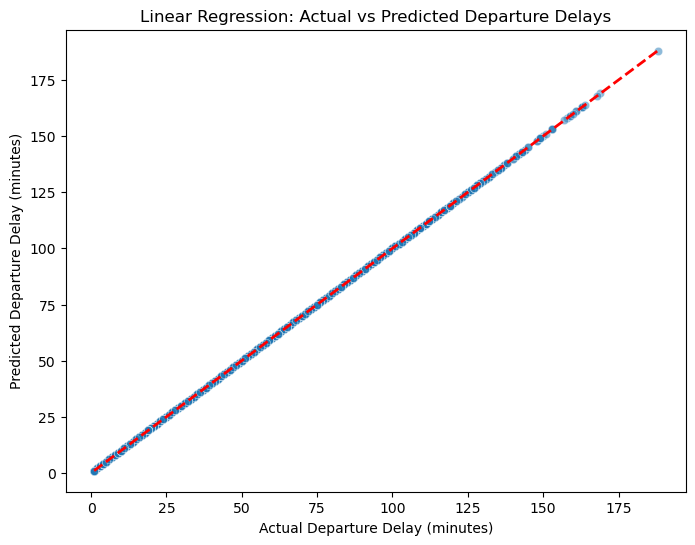

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('Linear Regression: Actual vs Predicted Departure Delays')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, linestyle='--')  
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10) 
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Decision Tree Mean Squared Error:", round(mse, 2))
print("Decision Tree R² Score:", round(r2 * 100, 2), "%")


Decision Tree Mean Squared Error: 0.0
Decision Tree R² Score: 100.0 %


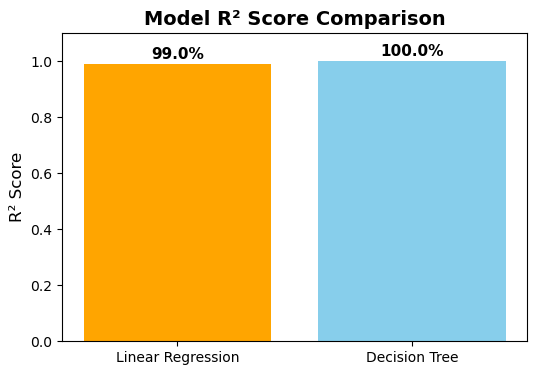

In [16]:
import matplotlib.pyplot as plt
acc_lin = 0.99        # Linear Regression (99%)
acc_dt = 1.00         # Decision Tree (100%)
plt.figure(figsize=(6,4))
plt.bar(['Linear Regression', 'Decision Tree'],
        [acc_lin, acc_dt],
        color=['orange', 'skyblue'])

plt.title('Model R² Score Comparison', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.ylim(0, 1.1)
for i, acc in enumerate([acc_lin, acc_dt]):
    plt.text(i, acc + 0.02, f'{acc*100:.1f}%', ha='center', fontsize=11, fontweight='bold')
plt.show()


<h2>conclusion<h2>

The dataset uses features (X) such as month, day_of_week, distance, taxi_out, taxi_in, air_time, origin, origin city, and origin state (all encoded) to predict the target variable (y), which is departure delay. Applying Linear Regression resulted in an R² score of 99%, showing a strong fit, while Decision Tree Regressor achieved 100% R², indicating an almost perfect prediction of departure delays